In [1]:
! pip install btester requests tqdm yfinance quantstats==0.0.59

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import yfinance as yf
import pandas as pd

start = '2006-01-01'
end = '2024-01-01'

symbol = 'AAPL'

data = yf.download(symbol, start, end)
benchmark = data['Close']

[*********************100%%**********************]  1 of 1 completed


In [3]:
from btester import Strategy

def EMA(ser: pd.Series, period: int):
    return ser.ewm(span=period, adjust=False).mean().values

class MACrossoverStrategy(Strategy):
    def init(self, fast_period: int, slow_period: int):
        self.fast_ma = EMA(self.data['Close'], fast_period)
        self.slow_ma = EMA(self.data['Close'], slow_period)

    def next(self, i, record):
        if self.fast_ma[i-1] > self.slow_ma[i-1]:
            self.open(price=record['Open'])
        else:
            self.close(price=record['Open'])

In [4]:
from btester import Backtest
backtest = Backtest(MACrossoverStrategy, data, commission=.001, cash=1e6)

In [5]:
import quantstats as qs
from itertools import product
from tqdm.contrib.concurrent import process_map

parameters = ['Fast MA','Slow MA']
values = [[5, 10, 15, 20, 25], [30, 35, 40, 45, 50]]

def run(v):
    result = backtest.run(*v)
    returns = result.returns
    return [*v, returns.iloc[0], returns.iloc[-1], qs.stats.max_drawdown(returns) * 100, qs.stats.cagr(returns) * 100, qs.stats.sharpe(returns)]

optimization_results = process_map(run, list(product(*values)))
optimization_results = pd.DataFrame(optimization_results, columns=[*parameters,'Initial Capital','Cumulative Return','Max Drawdown (%)','CAGR (%)','Sharpe Ratio'])
optimization_results.set_index([*parameters], inplace=True)

100%|██████████| 25/25 [00:00<00:00, 42.10it/s]


In [6]:
optimization_results_sorted = optimization_results.sort_values('Sharpe Ratio', ascending=False)
optimization_results_sorted

Initial Capital  Cumulative Return  Max Drawdown (%)  \
Fast MA Slow MA                                                         
15      40          1.031712e+06       4.259749e+07        -32.368637   
5       30          1.031712e+06       3.331955e+07        -26.957375   
15      50          1.031712e+06       4.206925e+07        -31.849891   
        45          1.031712e+06       3.933729e+07        -29.853600   
20      30          1.031712e+06       3.677927e+07        -27.761538   
15      35          1.031712e+06       3.592651e+07        -30.693334   
25      35          1.031712e+06       3.904566e+07        -28.792054   
5       45          1.031712e+06       3.351782e+07        -28.950665   
        35          1.031712e+06       3.107334e+07        -26.041942   
10      45          1.031712e+06       3.447149e+07        -28.879571   
20      45          1.031712e+06       3.660443e+07        -27.593604   
        35          1.031712e+06       3.331321e+07        -32.471298   
        40          1.031712e+06       3.445833e+07        -30.539176   
5       40          1.031712e+06       2.973629e+07        -32.077388   
10      30          1.031712e+06       2.907231e+07        -27.930253   
        50          1.031712e+06       3.162149e+07        -34.680739   
25      40          1.031712e+06       3.351111e+07        -29.950521   
        30          1.031712e+06       2.831381e+07        -30.935617   
15      30          1.031712e+06       2.647738e+07        -28.246007   
20      50          1.031712e+06       3.052529e+07        -31.462612   
10      35          1.031712e+06       2.592967e+07        -28.847491   
25      45          1.031712e+06       2.913173e+07        -36.083784   
10      40          1.031712e+06       2.484586e+07        -29.274934   
25      50          1.031712e+06       2.768966e+07        -34.720589   
5       50          1.031712e+06       2.304413e+07        -28.449735   

                  CAGR (%)  Sharpe Ratio  
Fast MA Slow MA                           
15      40       22.965066      1.027992  
5       30       21.298074      1.010103  
15      50       22.879839      1.005542  
        45       22.422252      1.001510  
20      30       21.965731      1.001184  
15      35       21.806855      0.998207  
25      35       22.371646      0.986157  
5       45       21.338068      0.984059  
        35       20.828587      0.983252  
10      45       21.527366      0.978880  
20      45       21.933443      0.969251  
        35       21.296791      0.968217  
        40       21.524788      0.961070  
5       40       20.533663      0.959638  
10      30       20.382519      0.958044  
        50       20.946044      0.951926  
25      40       21.336718      0.947933  
        30       20.205818      0.927726  
15      30       19.758756      0.926014  
20      50       20.709176      0.923504  
10      35       19.619743      0.919874  
25      45       20.396177      0.910132  
10      40       19.336295      0.902522  
25      50       20.057028      0.890006  
5       50       18.838169      0.883666

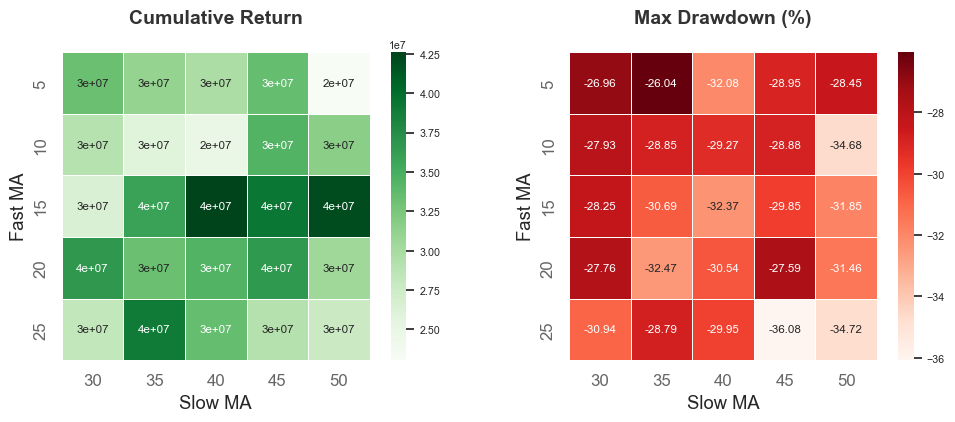

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].set_title('Cumulative Return\n', fontsize=14, fontweight='bold')
ax[1].set_title('Max Drawdown (%)\n', fontsize=14, fontweight='bold')

reshape = lambda d: pd.DataFrame(d.values.reshape(len(d.index.levels[0]), len(d.index.levels[1])), d.index.levels[0], d.index.levels[1])

sns.set(font_scale=.7)
sns.heatmap(reshape(optimization_results['Cumulative Return']), ax=ax[0], annot=True, fmt='.0g', linewidth=.5, square=True, cmap='Greens')
sns.heatmap(reshape(optimization_results['Max Drawdown (%)']), ax=ax[1], annot=True, fmt='.2f', linewidth=.5, square=True, cmap='Reds')

plt.show()

In [8]:
best_params = optimization_results_sorted.index[0]
best_params

(15, 40)

In [9]:
result = backtest.run(*best_params)

In [10]:
import quantstats as qs
qs.reports.metrics(result.returns, benchmark)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2006-01-03  2006-01-03
End Period          2023-12-29  2023-12-29
Risk-Free Rate      0.0%        0.0%
Time in Market      69.0%       100.0%

Cumulative Return   4,028.82%   7,111.83%
CAGR﹪              22.97%      26.84%

Sharpe              1.03        0.9
Prob. Sharpe Ratio  100.0%      99.99%
Sortino             1.55        1.32
Sortino/√2          1.09        0.94
Omega               1.24        1.24

Max Drawdown        -32.37%     -60.87%
Longest DD Days     724         720

Gain/Pain Ratio     0.24        0.18
Gain/Pain (1M)      1.29        1.0

Payoff Ratio        1.11        1.11
Profit Factor       1.24        1.18
Common Sense Ratio  1.39        1.25
CPC Index           0.73        0.69
Tail Ratio          1.12        1.07
Outlier Win Ratio   7.15        3.44
Outlier Loss Ratio  4.17        3.54

MTD                 1.36%       1.36%
3M                  5.13%       12

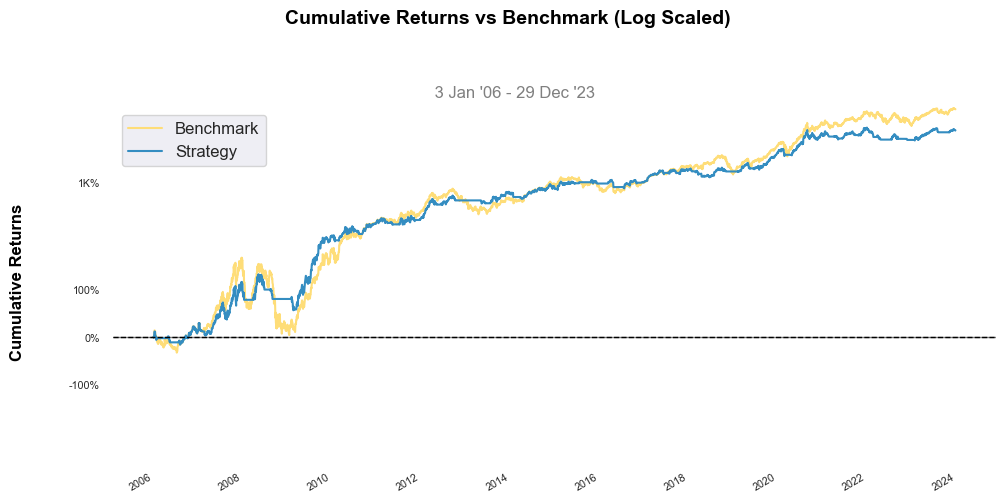

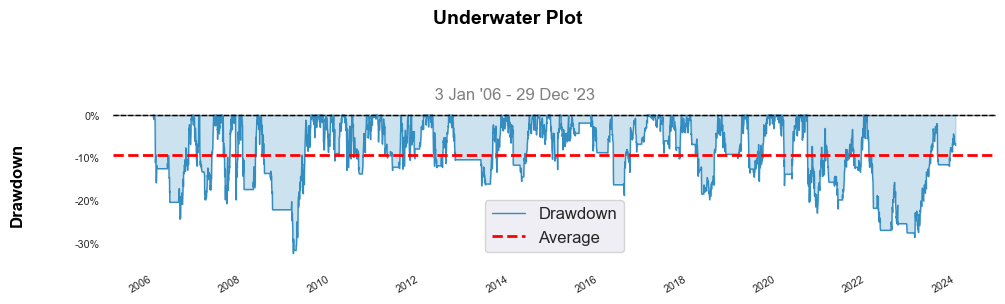

In [11]:
qs.plots.log_returns(result.returns, benchmark, fontname='sans-serif')
qs.plots.drawdown(result.returns, figsize=(10,3), fontname='sans-serif')

In [14]:
trades = pd.DataFrame(result.trades)
trades

,symbol,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
0,None,2006-01-03,2006-01-04,2.585000,2.683214,386460.728920,3.795582e+04,3.799378,2035.957818,1.035920e+06
1,None,2006-01-05,2006-01-06,2.672500,2.687500,387234.805420,5.808563e+03,0.561276,2075.578516,1.039653e+06
2,None,2006-01-09,2006-02-01,2.740357,2.676786,379006.918186,-2.409384e+04,-2.319806,2053.134624,1.013506e+06
3,None,2006-04-28,2006-05-19,2.477857,2.259286,408616.531180,-8.931180e+04,-8.820976,1935.674957,9.222584e+05
4,None,2006-07-31,2007-02-05,2.386786,3.010714,386015.782682,2.408461e+05,26.140931,2083.520202,1.161021e+06
5,None,2007-02-23,2007-03-01,3.184286,3.001071,364245.251516,-6.673525e+04,-5.753727,2252.986950,1.092033e+06
6,None,2007-03-02,2007-03-05,3.098929,3.067500,352038.336516,-1.106415e+04,-1.014183,2170.819422,1.078798e+06
7,None,2007-03-07,2007-08-17,3.144643,4.357500,342716.173652,4.156657e+05,38.568988,2571.105793,1.491892e+06
8,None,2007-08-27,2008-01-16,4.763929,5.901071,312851.429872,3.557566e+05,23.869840,3336.560488,1.844312e+06
9,None,2008-04-01,2008-07-01,5.225000,5.865357,352625.823493,2.258064e+05,12.255637,3910.746209,2.066208e+06


In [13]:
open_positions = pd.DataFrame(result.open_positions)
open_positions

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value
0,None,2023-11-09,2023-12-29,182.960007,192.529999,221251.181656,2.117372e+06,5.230647,4.259749e+07
